# Part 1- Sentiment analysis of stock news

## Import the libraries

In [148]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
%matplotlib inline
from newsapi import NewsApiClient
from datetime import datetime, timedelta
from dotenv import load_dotenv
load_dotenv()

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Fetch the stock OHLC

In [149]:
# Yahoo finance is used
stock_data= yf.download(tickers= 'MSFT', period= '5y')
stock_data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-06,212.169998,216.490005,211.940002,212.250000,212.250000,35930700
2021-01-07,214.039993,219.339996,213.710007,218.289993,218.289993,27694500
2021-01-08,218.679993,220.580002,217.029999,219.619995,219.619995,22956200
2021-01-11,218.470001,218.910004,216.729996,217.490005,217.490005,23047000
2021-01-12,216.500000,217.100006,213.320007,214.929993,214.929993,23226800


In [150]:
# Get only the closing price and round to 2 decimals
stock_close= round (stock_data['Close'], 2)
stock_close.tail()

Date
2021-01-06    212.25
2021-01-07    218.29
2021-01-08    219.62
2021-01-11    217.49
2021-01-12    214.93
Name: Close, dtype: float64

In [151]:
# Calculate the daily returns
returns= stock_close.pct_change()*100
returns.tail()

Date
2021-01-06   -2.592933
2021-01-07    2.845701
2021-01-08    0.609281
2021-01-11   -0.969857
2021-01-12   -1.177066
Name: Close, dtype: float64

In [152]:
# Convert to a dataframe and sort by descending date
returns_df= pd.DataFrame(returns)
returns_df.sort_index(ascending= False, inplace= True)

returns_df.rename(columns= {'Close':'pct_change'}, inplace= True)
returns_df.head()

,pct_change
Date,
2021-01-12,-1.177066
2021-01-11,-0.969857
2021-01-08,0.609281
2021-01-07,2.845701
2021-01-06,-2.592933


### Download the VADER Lexicon

In [ ]:
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer= SentimentIntensityAnalyzer()

### Fetch the news

In [ ]:
# Import the libraries
import requests
import json

In [ ]:
# Check for the STOCK_NEWS_API key
stock_news_api= os.getenv("STOCK_NEWS_API")
type (stock_news_api)

In [220]:
# Define the base request URL
request_url = "https://stocknewsapi.com/api/v1?tickers=MSFT&items=50&token="

# Concatenate request_url and api_key. Store as new variable
request_url= request_url+ stock_news_api

In [221]:
# Execute get request
response_data= requests.get(request_url).json()

In [222]:
# Print the response data
print (json.dumps (response_data, indent= 4))

{
    "data": [
        {
            "news_url": "https://www.zacks.com/stock/news/1245465/microsoft-msft-stock-sinks-as-market-gains-what-you-should-know",
            "image_url": "https://cdn.snapi.dev/images/v1/y/2/microsoft-4.jpg",
            "title": "Microsoft (MSFT) Stock Sinks As Market Gains: What You Should Know",
            "text": "In the latest trading session, Microsoft (MSFT) closed at $214.93, marking a -1.18% move from the previous day.",
            "source_name": "Zacks Investment Research",
            "date": "Tue, 12 Jan 2021 18:48:15 -0500",
            "topics": [],
            "sentiment": "Negative",
            "type": "Article",
            "tickers": [
                "MSFT"
            ]
        },
        {
            "news_url": "https://www.prnewswire.com/news-releases/microsoft-announces-quarterly-earnings-release-date-301206871.html",
            "image_url": "https://cdn.snapi.dev/images/v1/c/o/conf4---2g3y824wt2.jpg",
            "title": "Micr

## Get the news text, date and the sentiment from response data

In [ ]:
def combined_df(text):
    all_dates= []
    all_articles= []
    all_sentiments= []
    
    for article in text['data']:
        date= all_dates.append(article['date'])
        articles= all_articles.append(article['text'])
        sentiments= all_sentiments.append(article['sentiment'])
        text_sentiments= pd.DataFrame ({
            'date': date,
            'articles':articles,
            'sentiments':sentiments,
        }
        )
    return text_sentiments

In [ ]:
# for article in response_data['data']:
#         print (len (article))

In [ ]:
# text_sentiment_df= combined_df(response_data )
# text_sentiment_df.head()

In [223]:
all_articles= []
all_sentiments= []
all_dates= []
for article in response_data['data']:
    all_articles.append(article['text'])
    all_sentiments.append(article['sentiment'])
    all_dates.append(article['date'])

In [224]:
all_articles_df= pd.DataFrame(all_articles, columns= ['text'])
all_sentiments_df= pd.DataFrame(all_sentiments, columns= ['sentiment'])

all_dates_df= pd.DataFrame(all_dates, columns= ['date'])
all_dates_df['date']= pd.to_datetime(all_dates_df['date']).dt.date


text_sentiment= pd.concat([all_dates_df, all_articles_df, all_sentiments_df], axis= 1)
text_sentiment.tail()

,date,text,sentiment
45,2020-12-31,An illicit account associated with the widespr...,Negative
46,2020-12-31,The hacking group behind the SolarWinds compro...,Negative
47,2020-12-31,Not everyone follows the guidance of analysts'...,Positive
48,2020-12-31,The e-commerce and cloud giant still has plent...,Positive
49,2020-12-31,Jason Ware of Albion Financial Group discusses...,Positive


In [145]:
# Set the date as index
text_sentiment.set_index('date', inplace= True)
text_sentiment.head()

,text,sentiment
date,,
2021-01-12,"In the latest trading session, Microsoft (MSFT...",Negative
2021-01-12,"REDMOND, Wash., Jan. 12, 2021 /PRNewswire/ -- ...",Neutral
2021-01-12,Microsoft (MSFT) is collaborating with Verily ...,Neutral
2021-01-12,Microsoft (MSFT) has released its new Surface ...,Positive
2021-01-11,Data indicates The Dogs of the Dow outperform ...,Neutral


In [153]:
# Merge the pct change with the above df
text_sentiment_returns= pd.merge(text_sentiment, returns_df, left_index= True, right_index= True)
text_sentiment_returns.sort_index(ascending= False, inplace= True)
text_sentiment_returns.head()

,text,sentiment,pct_change
2021-01-12,Microsoft (MSFT) has released its new Surface ...,Positive,-1.177066
2021-01-12,Microsoft (MSFT) is collaborating with Verily ...,Neutral,-1.177066
2021-01-12,"REDMOND, Wash., Jan. 12, 2021 /PRNewswire/ -- ...",Neutral,-1.177066
2021-01-12,"In the latest trading session, Microsoft (MSFT...",Negative,-1.177066
2021-01-11,Alphabet's research subsidiary Verily has anno...,Positive,-0.969857


In [154]:
text_sentiment_returns.reset_index(inplace= True)
text_sentiment_returns.head()

,index,text,sentiment,pct_change
0,2021-01-12,Microsoft (MSFT) has released its new Surface ...,Positive,-1.177066
1,2021-01-12,Microsoft (MSFT) is collaborating with Verily ...,Neutral,-1.177066
2,2021-01-12,"REDMOND, Wash., Jan. 12, 2021 /PRNewswire/ -- ...",Neutral,-1.177066
3,2021-01-12,"In the latest trading session, Microsoft (MSFT...",Negative,-1.177066
4,2021-01-11,Alphabet's research subsidiary Verily has anno...,Positive,-0.969857


### Create the sentiment scores DF

In [155]:
polarity= []

for content in text_sentiment_returns['text']:
    try:
        # Calculate the polarity score
        sentiment= analyzer.polarity_scores(content)
        compound= sentiment['compound']
#         positive= sentiment['pos']
#         negative= sentiment['neg']
#         neutral= sentiment['neu']
        
        polarity.append({
            "compound": compound,
#             "positive": positive,
#             "negative": negative,
#             "neutral": neutral
        })
        
    except AttributeError:
        pass
    
# Create dataframe
polarity_df= pd.DataFrame(polarity)
polarity_df.head()

,compound
0,0.0000
1,0.0000
2,0.0000
3,0.0000
4,0.1779


In [156]:
text_sentiment_returns_polarity= pd.concat([text_sentiment_returns, polarity_df], axis= 1)
text_sentiment_returns_polarity.set_index('index', inplace= True)
text_sentiment_returns_polarity.head()

,text,sentiment,pct_change,compound
index,,,,
2021-01-12,Microsoft (MSFT) has released its new Surface ...,Positive,-1.177066,0.0000
2021-01-12,Microsoft (MSFT) is collaborating with Verily ...,Neutral,-1.177066,0.0000
2021-01-12,"REDMOND, Wash., Jan. 12, 2021 /PRNewswire/ -- ...",Neutral,-1.177066,0.0000
2021-01-12,"In the latest trading session, Microsoft (MSFT...",Negative,-1.177066,0.0000
2021-01-11,Alphabet's research subsidiary Verily has anno...,Positive,-0.969857,0.1779


## Tokenization, Lemmatization

In [157]:
# Importing the Libraries and Functions
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [158]:
# Instantiate the lemmatizer
lemmatizer= WordNetLemmatizer()

In [ ]:
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the stop words
    stop_words= set (stopwords.words('english'))
   
    # Remove the punctuation and substitute
    non_alpha= re.compile('[^a-zA-Z ]')
    re_clean= non_alpha.sub('', str (text))
    
    # Tokenize the words
    words= word_tokenize(re_clean)
    
    # Lemmatize Article words into root words
    root_words= []
    for values in words:
        root_words.append(lemmatizer.lemmatize(values))
        
    # Remove stop words and Convert the words to lowercase
    tokens= []
    for all_words in root_words:
        if all_words.lower() not in stop_words:
            tokens.append(all_words.lower())
    
    return tokens

In [ ]:
# Apply the tokenizer function to the news text column
text_sentiment_returns_polarity['tokenized']= text_sentiment_returns_polarity['text'].apply(tokenizer)
text_sentiment_returns_polarity.head()

## N-grams, WordCloud

In [ ]:
# Import the libraries and functions
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15.0, 15.0]

In [ ]:
# Generate the word cloud
returns_big_text= ''.join (str (text_sentiment_returns_polarity["text"]))

returns_wc= WordCloud().generate(returns_big_text)

plt.imshow(returns_wc)
plt.axis("off")
plt.title('WordCloud', fontsize= 25)
plt.show()

## Part 2- Regression and Deep Learning prediction of returns

## Linear Regression

In [209]:
# Create a train/test split for the data
train= text_sentiment_returns_polarity['2020-12']
test= text_sentiment_returns_polarity['2021-01']

In [210]:
# Create X_train, X_test, y_train, y_test
X_train= train['compound'].to_frame()
y_train= train['pct_change']

X_test= test['compound'].to_frame()
y_test= test['pct_change']

In [211]:
# Create a linear regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

lr_model= LinearRegression()
lr_model.fit (X_train, y_train)

LinearRegression()

## Make predictions using the test data

In [212]:
# Make a prediction of "y" values using just the test dataset
lr_predictions= lr_model.predict(X_test)

In [213]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame:
results= y_test.to_frame()
results['predicted return']= lr_predictions
results.head()

,pct_change,predicted return
index,,
2021-01-12,-1.177066,0.333815
2021-01-12,-1.177066,0.333815
2021-01-12,-1.177066,0.333815
2021-01-12,-1.177066,0.333815
2021-01-11,-0.969857,0.333815


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026C2ECC9D88>,
      dtype=object)

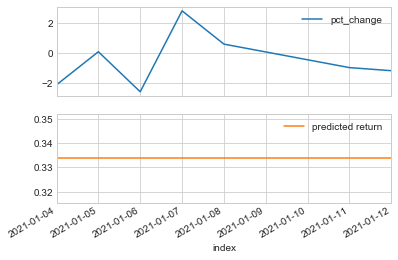

In [214]:
results.plot(subplots= True)

## Deep Learning

In [226]:
import hvplot.pandas
# Set the random seed for reproducibility
from numpy.random import seed
seed (1)
from tensorflow import random
random.set_seed(2)

#### Define a function for features and target

In [227]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    
    for rows in range(len(df) - window - 1):
        features = df.iloc[rows:(rows + window), feature_col_number]
        target = df.iloc[(rows + window), target_col_number]
        
        X.append(features)
        y.append(target)
    
    return np.array(X), np.array(y).reshape(-1, 1)

In [229]:
# Predict returns using a 1 day window of previous fng values
window = 1

# The dataframe under consideration is text_sentiment_returns_polarity
# Column 3- compund score is the feature column
# Column 2- returns is the target column
feature_col_number = 3
target_col_number = 2

X, y = window_data(text_sentiment_returns_polarity, window, feature_col_number, target_col_number)

In [230]:
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]} \n")
print (f"Length of X: {len (X)}")

X sample values:
[[0.    ]
 [0.    ]
 [0.    ]
 [0.    ]
 [0.1779]] 

y sample values:
[[-1.17706561]
 [-1.17706561]
 [-1.17706561]
 [-0.96985703]
 [-0.96985703]] 

Length of X: 44


#### Split the data into training and testing

In [231]:
# Use 70% of the data for training and the remainder for testing
split= int (0.7* len(X))

X_train= X[: split]
X_test= X[split: ]

y_train= y[: split]
y_test= y[split: ]

In [232]:
from sklearn.preprocessing import MinMaxScaler

# Use the MinMaxScaler to scale data between 0 and 1.
scaler= MinMaxScaler()

scaler.fit(X)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

scaler.fit(y)
y_train_scaled= scaler.transform(y_train)
y_test_scaled= scaler.transform(y_test)

In [233]:
print (f"X_train_scaled sample values:\n {X_train_scaled[:2]}\n")
print (f"y_train_scaled sample values:\n {y_train_scaled[:2]}")

X_train_scaled sample values:
 [[0.36308042]
 [0.36308042]]

y_train_scaled sample values:
 [[0.26033506]
 [0.26033506]]


In [234]:
print (f"X_train_scaled shape: {X_train_scaled.shape}")
print (f"X_test_scaled shape: {X_test_scaled.shape}")
print (f"y_train_scaled shape: {y_train_scaled.shape}")
print (f"y_test_scaled shape: {y_test_scaled.shape}")

X_train_scaled shape: (30, 1)
X_test_scaled shape: (14, 1)
y_train_scaled shape: (30, 1)
y_test_scaled shape: (14, 1)


#### Reshape the feature data

In [235]:
# Reshape the features for the model
X_train_reshaped= X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

X_test_reshaped= X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [236]:
print (f"X_train_reshaped sample values:\n{X_train_reshaped[:1]} \n")
print (f"X_test_reshaped sample values:\n{X_test_reshaped[:1]}")

X_train_reshaped sample values:
[[[0.36308042]]] 

X_test_reshaped sample values:
[[[0.87392448]]]


In [237]:
print (f"X_train_reshaped shape: {X_train_reshaped.shape}")
print (f"X_test_reshaped shape: {X_test_reshaped.shape}")

X_train_reshaped shape: (30, 1, 1)
X_test_reshaped shape: (14, 1, 1)


### Build and train the LSTM RNN

In [238]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN model structure

In this model the previous closing price is used to predict the next closing price

In [240]:
# Define the LSTM model
nn_model= Sequential()

number_units= 1

# Neural Network layer
nn_model.add (LSTM (units= number_units, input_shape= (X_train_reshaped.shape[1], 1)))

# Output NN layer
nn_model.add (Dense (units= 1))

In [242]:
# Compile the model
nn_model.compile (loss= 'mean_squared_error', optimizer= 'adam')

In [243]:
# Summarize the model
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1)                 12        
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


#### Train the LSTM model

In [244]:
# Do not shuffle the data
nn_model.fit (X_train_reshaped, y_train_scaled, epochs= 10, batch_size= 1, shuffle= False)

Epoch 1/10
30/30 [==============================] - 1s 1ms/step - loss: 0.0797
Epoch 2/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0669
Epoch 3/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 4/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0522
Epoch 5/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0475
Epoch 6/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0441
Epoch 7/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0416
Epoch 8/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0399
Epoch 9/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0387
Epoch 10/10
30/30 [==============================] - 0s 2ms/step - loss: 0.0379


## Model performance

In [245]:
nn_model.evaluate (X_test_reshaped, y_test_scaled)

1/1 [==============================] - 1s 716ms/step - loss: 0.0655


0.06552258878946304

In [246]:
# Make predictions
predicted= nn_model.predict (X_test_reshaped)
predicted[:5]

array([[0.3484498 ],
       [0.22830728],
       [0.33747754],
       [0.32750705],
       [0.35495803]], dtype=float32)

In [247]:
# Inverse transform the array to get the original values
predicted_prices= scaler.inverse_transform (predicted)
real_prices= scaler.inverse_transform(y_test_scaled.reshape(-1,1))

In [250]:
# Create a DataFrame of Real and Predicted values
real_predicted = pd.DataFrame(
    {
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, 
    index = text_sentiment_returns_polarity.index[-len(real_prices): ]
) 

real_predicted.head()

,Real,Predicted
index,,
2021-01-04,-2.126607,-0.697842
2021-01-04,-2.126607,-1.351253
2021-01-04,-2.126607,-0.757516
2021-01-04,-2.126607,-0.811742
2021-01-04,-2.126607,-0.662446


In [251]:
# Plot the real vs predicted values as a line chart
real_predicted.hvplot(title= 'Real vs predicted returns')

:NdOverlay   [Variable]
   :Curve   [index]   (value)